# NLP Challenge 1: Product classification

In [63]:
import json
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import islice

import pickle
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics, svm
from sklearn.model_selection import GridSearchCV, KFold
import gensim
import gensim.downloader as gensim_api

import nltk
nltk.data.path.append(r"C:\Users\TQU3HC\Desktop\nltk_data")
# Download set of word dicts
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('omw-1.4')

## Read Data

In [64]:
data = []
with open('Dataset1/data.json',encoding="utf8") as file:
    for line in file:
        #print(line.rstrip())
        data.append(json.loads(line.rstrip()))

In [65]:
len(data)

14999

In [96]:
data[20]['data']

'Title: Khăn ướt cho bé sơ sinh không mùi Bibo 100 tờ không mùi mềm mại an toàn Kukushop_Kids KU01\n\nDescription: Khăn ướt cho bé mềm mịn an toàn cao cấp Đồ dùng cho bé - đồng hành cùng sự phát triển của con yêu Làm mẹ là thiên chức quý giá nhất của người phụ nữ. 9 tháng 10 ngày con phát triển trong bụng mẹ, lắng nghe từng cử động của con khiến cho tình mẫu tử thêm phần khăng khít. Chính vì thế, bố mẹ nào cũng muốn dành những điều tốt đẹp nhất ngay từ giây phút con chào đời. Để dễ dàng hơn trong việc chăm sóc con trẻ, bố mẹ cần sắm rất nhiều thứ đồ dùng cho bé. Một trong số đồ sơ sinh phải kể đến là các sản phẩm khăn giấy ướt cho bé sử dụng khi ăn uống, lau chùi vệ sinh sạch sẽ cho trẻ khi ở nhà, đi chơi du lịch tiện lợi Khăn ướt cho bé Hãng khăn: BIBO Khăn có: 100 tờ Khăn ướt Moony mềm mại không gây kích ứng da trẻ nhỏ Không dùng hóa chất, không mùi an toàn tuyệt đối cho da Bé Sợi dai, không xù không sổ, dễ dàng làm sạch Dùng được cho bé sơ sinh Túi đựng nhỏ gọn, tiện dụng Dùng để vệ

In [67]:
train = pd.DataFrame.from_dict(data, orient='columns')
train.reset_index(level=0, inplace=True)
train

,index,id,data,label,link
0,0,lazada!2b243705-5f37-5c7f-8c9d-eae1e9447319,Title: Sữa Bột Vinamilk Nguyên Kem 900g (hộp s...,Milk,https://www.lazada.vn/products/i-i1210092788-s...
1,1,lazada!5651ce36-38f9-5694-8e83-57c16900b088,Title: Gold Hepolin Sản phẩm bổ gan chính hãng...,Spam,https://www.lazada.vn/products/i-i1227814631-s...
2,2,shopee!24e50dd4-cd64-5c54-8623-480f9ba7a255,Title: [Mã FMCGMALL giảm 8% đơn từ 250K] Sữa A...,Milk,https://shopee.vn/i-i.54435575.3082645195
3,3,shopee!aca2ab28-aec1-50a8-b83a-322d5f6c4e01,Title: Sữa Semper Nga số 1\n\nDescription: #Sữ...,Milk,https://shopee.vn/i-i.32937244.1317606869
4,4,lazada!97998517-ba42-50ef-b575-76a9d22a04a5,Title: [HCM]Tẩy Giun Sán BIO-RANTEL Cho Chó Mè...,Spam,https://www.lazada.vn/products/i-i318836042-s5...
...,...,...,...,...,...
14994,14994,shopee!bfdbfa2a-3ae8-5017-960d-ca219498d8ee,Title: [Date mới nhất] Sữa Aptamil Bạc Profutu...,Milk,https://shopee.vn/i-i.206371982.13830880179
14995,14995,lazada!99829873-751c-5238-98a6-7ef4f2b681db,Title: [HCM]Đông Trùng Hạ Thảo KIM CƯƠNG VÀNG ...,Spam,https://www.lazada.vn/products/i-i620480081-s1...
14996,14996,lazada!ba23c645-fc00-532d-9a94-495e1ff484b2,Title: MEYPPA SHOP TX3mini Bộ giải mã video 1G...,Spam,https://www.lazada.vn/products/i-i1589124406-s...
14997,14997,shopee!e5f9b762-ac9f-59d1-9183-5ffaea1718ae,Title: Sữa bột Optimum gold 2 800g\n\nDescript...,Milk,https://shopee.vn/i-i.27531940.7103072041


In [68]:
train.label.unique()

array(['Milk', 'Spam'], dtype=object)

In [75]:
product_id = train['id'].tolist()
titles = train['data'].tolist()
labels = train['label'].tolist()

In [76]:
# Convert a list of label to a list of label indices
label_dict = dict(
    zip(
        sorted(set(labels), key=labels.index), 
        range(len(labels))
    )
)
label_set = sorted(set(labels), key=labels.index)

# Convert label from string to numeric indices
label_indices=[label_dict[label] for label in labels]

In [77]:
label_dict

{'Milk': 0, 'Spam': 1}

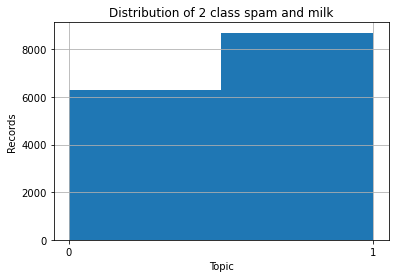

In [78]:
label_series = pd.Series(label_indices)

label_series.hist(bins=2)
plt.xticks(range(2))

plt.ylabel('Records')
plt.xlabel('Topic')
plt.title('Distribution of 2 class spam and milk')
plt.show()

## Data Preprocessing

In [106]:
import re, string
from pyvi import ViTokenizer, ViPosTagger
import emoji

def give_emoji_free_text(text):
    allchars = [str for str in text.decode('utf-8')]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.decode('utf-8').split() if not any(i in str for i in emoji_list)])
    return clean_text

def remove_icon(text):
    text = text.lower()
    s = ''
    pattern = r"[a-zA-ZaăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ,._]"
    
    for char in text:
        if char !=' ':
            if len(re.findall(pattern, char)) != 0:
                s+=char
            elif char == '_':
                s+=char
        else:
            s+=char
    s = re.sub('\\s+',' ',s).strip()
    return s.strip()

def simple_processing(text):
    text = text.strip()
    text = text.replace('Title: ', '')
    text = text.replace('Description: ', '')
    text = re.sub(r"\s+"," ", text)
    text = remove_icon(text)
    text = ViTokenizer.tokenize(text)
    for punc in string.punctuation:
        if punc != "_":
            text = text.replace(punc, "")
    text = text.strip()
    text = re.sub("\\s+"," ", text).lower()
    return text

In [107]:
processed_titles = [simple_processing(title) for title in titles]


In [108]:
for i in range(10):
    print('##########################################################')
    print("preprocessed: " + titles[i])
    print("processed: " + processed_titles[i])

##########################################################
preprocessed: Title: Sữa Bột Vinamilk Nguyên Kem 900g (hộp sắt/thiếc)

Description: Chất lượng sản phẩm tốt.Cam kết sản phẩm như mô tả.Sản phẩm dễ sử dụng, có độ bền cao.Sản phẩm như hình. MÔ TẢ SẢN PHẨMSỮA BỘT NGUYÊN KEM CÓ ĐƯỜNG VINAMILK DINH DƯỠNG
processed: sữa bột vinamilk nguyên kem g hộp sắtthiếc chất_lượng sản_phẩm tốt cam_kết sản_phẩm như mô_tả sản_phẩm dễ sử_dụng có độ bền cao sản_phẩm như hình mô_tả sản phẩmsữa bột nguyên kem có đường vinamilk dinh_dưỡng
##########################################################
preprocessed: Title: Gold Hepolin Sản phẩm bổ gan chính hãng

Description: Công Dụng:Viên Bổ Gan Goldhepolin Trắng Hàn Quốc - Liều dùng:Mỗi ngày 1 viên - uống sau bữa ănQuy cách: Hộp: 60 viên x 870mgCách bảo quản: Bảo quản nơi khô ráo thoáng mát, tránh ánh nắng trực tiếpXuất xứ: Korean Ginseng Research Co., Ltd. - JECSCO
processed: gold hepolin sản_phẩm bổ gan chính hãng công dụngviên bổ gan goldhepolin trắng

## Split the data in to train and test set (80/20 ratio)

In [114]:
# Split train:test set from data
test_ratio = 0.2
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    processed_titles, label_indices, 
    test_size=test_ratio,
    stratify=label_indices
)

In [116]:
len(x_train), len(x_test)

(11999, 3000)

In [115]:
len(y_train), len(y_test)

(11999, 3000)

## Train Classifier model

In [109]:
# This function is to plot the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Feature extractor with different techniques

In [110]:
def get_TFIDF_feature_extractor(max_feature_dim=5000, ngram_range=(1,2)):
    
    tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=5000, ngram_range=ngram_range)
    
    return tfidf_vectorizer

In [111]:
def get_BoW_feature_extractor(max_feature_dim=5000, ngram_range=(1,2)):
    
    bow_vectorizer = feature_extraction.text.CountVectorizer(max_features=max_feature_dim, ngram_range=ngram_range)
    return bow_vectorizer

In [112]:
def get_W2V_feature_extractor(w2v_corpus, vector_size=300):
    
    w2v_vectorizer = gensim.models.word2vec.Word2Vec(w2v_corpus, vector_size=300,   
            window=8, min_count=1, sg=1)  #word2vec with embedding size is 300
    return w2v_vectorizer

In [113]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec, size=100):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = size

    def fit(self, X, y):
        return self

    def transform(self, X):
        X_ = []
       
        for sentence in X:
            temp = np.zeros(300)
            words = sentence.split(" ")
            for w in words:
              temp += self.word2vec.wv[w].reshape(( 300))
              
            X_.append(temp/len(words))
        return X_

In [117]:
# Extract TFIDF features
tfidf_extractor = get_TFIDF_feature_extractor()
tfidf_feature = tfidf_extractor.fit_transform(x_train)

In [118]:
# Extract BoW features
bow_extractor = get_BoW_feature_extractor()
bow_feature = bow_extractor.fit_transform(x_train)

In [120]:
# Create Word2Vec Corpus
w2v_corpus = []
for i in processed_titles:
  temp = i.split(" ")
  w2v_corpus.append(temp)

w2v_model = get_W2V_feature_extractor(w2v_corpus, vector_size=300) #create the w2v model based on the x_train corpus
mean_w2v_embedding = MeanEmbeddingVectorizer(w2v_model,300) #Create the mean embedding vectorizer
w2v_feature =  mean_w2v_embedding.transform(x_train)  #Embedd the training data

In [121]:
def optimize_model_parameter(model, tfidf_features, Y_train):
    '''
    Perform hyper parameter tuning for model
    '''
    best_model = model.fit(tfidf_features, Y_train)
    #print(svm_grid_model.best_estimator_) 
    
    # Estimate the best accuracy
    train_accuracy = best_model.best_score_ *100
    print("Accuracy for our training dataset with tuning is : {:.2f}%".format(train_accuracy) )
    return best_model

def evaluate_model(model, X_test, Y_test):
    '''
    Initial evaluate model on test set
    '''
    # Predict topic indices in x_test
    y_test_hat = model.predict(x_test)

    # Estimate the testing accuracy
    test_accuracy = metrics.accuracy_score(y_test,y_test_hat)*100
    print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
    return test_accuracy

In [124]:
def get_SVM_linear_model():
    '''
    Get linear SVM model and list of parameters
    '''
    # Initialize SVM model as a classifier
    svm_model = svm.SVC(probability=True) 

    # Define config for params
    param_grid = {'C': [ 50, 150, 100, 200, 300], 
                  'gamma': [1,0.1,0.01,0.001],
                  'kernel': ['linear', 'rbf']} 

    # Perform Grid search
    grid = GridSearchCV(
        svm_model, 
        param_grid, 
        refit = True, 
        verbose = 3, 
        cv=5,
        n_jobs=2
    )
    
    return grid

In [125]:
# Initialize SVM with Grid Search model
svm_grid_model = get_SVM_linear_model()

# Hyper parameter tuning
optimized_model = optimize_model_parameter(svm_grid_model, tfidf_feature, y_train)
# Classifier pipeline
model = pipeline.Pipeline([("vectorizer", tfidf_extractor),  
                           ("classifier", optimized_model)])

# Predict topic indices in x_test
y_test_hat = model.predict(x_test)

# Evaluate on test set
evaluate_model(model, x_test, y_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

In [ ]:
# Print the details of classification results
print(metrics.classification_report(y_test, y_test_hat))
# Plot confusion matrix
confus_mat = metrics.confusion_matrix(y_test, y_test_hat)
disp = plot_confusion_matrix(
    confus_mat, 
    target_names=sorted(set(labels), key=labels.index)
)